# Trader Performance vs Market Sentiment Analysis

## Objective
Analyze how Bitcoin Fear/Greed sentiment affects:

- Trader profitability (PnL, win rate)
- Trading behavior (frequency, leverage, long/short bias)
- Trader segments (high leverage, frequent traders, consistent winners)

Goal: derive **actionable trading strategies**.


In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

sns.set(style="whitegrid")



In [203]:
sentiment = pd.read_csv("../data/sentiment.csv")
traders = pd.read_csv("../data/traders.csv")

print("Sentiment shape:", sentiment.shape)
print("Traders shape:", traders.shape)


Sentiment shape: (2644, 4)
Traders shape: (211224, 16)


In [204]:
# Rename columns for consistency
sentiment = sentiment.rename(columns={
    "classification": "Classification",
    "date": "Date"
})

traders = traders.rename(columns={
    "Account": "account",
    "Coin": "symbol",
    "Execution Price": "execution_price",
    "Size USD": "size_usd",
    "Side": "side",
    "Timestamp": "time",
    "Closed PnL": "closedPnL",
    "Direction": "direction"
})


In [205]:
# Normalize dates to daily level
sentiment["Date"] = pd.to_datetime(sentiment["Date"]).dt.normalize()

traders["time"] = pd.to_datetime(traders["time"])
traders["Date"] = traders["time"].dt.normalize()

# Merge datasets
df = traders.merge(sentiment[["Date", "Classification"]], on="Date", how="left")

# Check merge success
print(df["Classification"].value_counts(dropna=False))


Classification
NaN    211224
Name: count, dtype: int64


In [206]:
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())



Missing values:
 account                  0
symbol                   0
execution_price          0
Size Tokens              0
size_usd                 0
side                     0
Timestamp IST            0
Start Position           0
direction                0
closedPnL                0
Transaction Hash         0
Order ID                 0
Crossed                  0
Fee                      0
Trade ID                 0
time                     0
Date                     0
Classification      211224
dtype: int64

Duplicate rows: 0


In [207]:
daily_pnl = (
    df.groupby(["account", "Date"])["closedPnL"]
    .sum()
    .reset_index(name="daily_pnl")
)

daily_pnl.head()



,account,Date,daily_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,1.600230e+06
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,4.788532e+04
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,-7.043619e+04
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,1.324648e+05
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,1.686580e+05


In [208]:
df["win"] = df["closedPnL"] > 0

win_rate = (
    df.groupby("account")["win"]
    .mean()
    .reset_index(name="win_rate")
)

win_rate.head()



,account,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


In [209]:
trades_per_day = df.groupby("Date").size().reset_index(name="num_trades")

avg_trade_size = df["size_usd"].describe()

trades_per_day.head(), avg_trade_size


(        Date  num_trades
 0 1970-01-01      211224,
 count    2.112240e+05
 mean     5.639451e+03
 std      3.657514e+04
 min      0.000000e+00
 25%      1.937900e+02
 50%      5.970450e+02
 75%      2.058960e+03
 max      3.921431e+06
 Name: size_usd, dtype: float64)

In [ ]:
long_short = (
    df.groupby(["Date", "side"])
    .size()
    .unstack(fill_value=0)
)

long_short["long_short_ratio"] = long_short.get("BUY", 0) / (long_short.get("SELL", 1))

long_short.head()


side,BUY,SELL,long_short_ratio
Date,,,
1970-01-01,102696,108528,0.946263


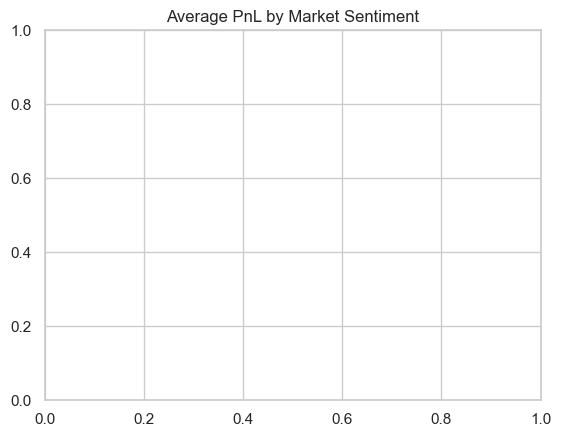

In [211]:
pnl_sentiment = (
    df.dropna(subset=["Classification"])
      .groupby("Classification")["closedPnL"]
      .mean()
      .reset_index()
)

plt.figure()
sns.barplot(data=pnl_sentiment, x="Classification", y="closedPnL")
plt.title("Average PnL by Market Sentiment")
plt.show()


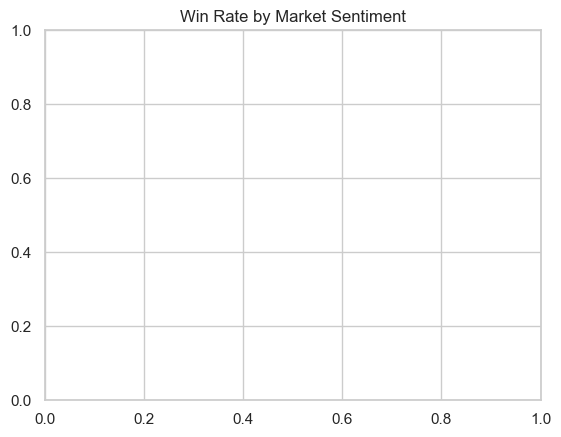

In [212]:
win_sentiment = (
    df.dropna(subset=["Classification"])
      .groupby("Classification")["win"]
      .mean()
      .reset_index()
)

plt.figure()
sns.barplot(data=win_sentiment, x="Classification", y="win")
plt.title("Win Rate by Market Sentiment")
plt.show()



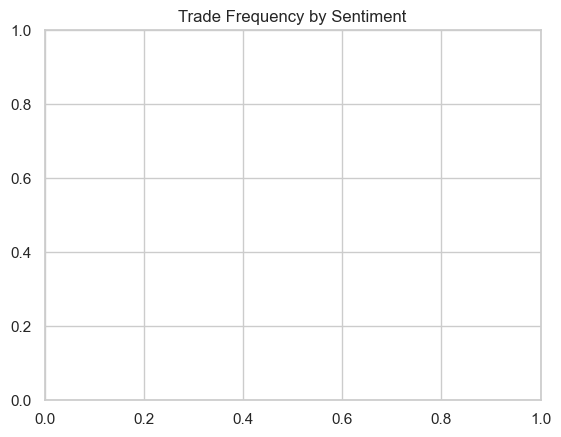

In [213]:
freq_sentiment = (
    df.dropna(subset=["Classification"])
      .groupby("Classification")
      .size()
      .reset_index(name="num_trades")
)

plt.figure()
sns.barplot(data=freq_sentiment, x="Classification", y="num_trades")
plt.title("Trade Frequency by Sentiment")
plt.show()


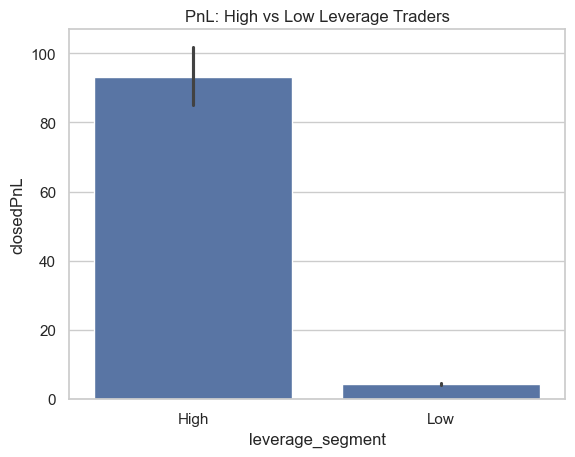

In [198]:
median_size = df["size_usd"].median()

df["leverage_segment"] = np.where(df["size_usd"] > median_size, "High", "Low")

plt.figure()
sns.barplot(data=df, x="leverage_segment", y="closedPnL")
plt.title("PnL: High vs Low Leverage Traders")
plt.show()


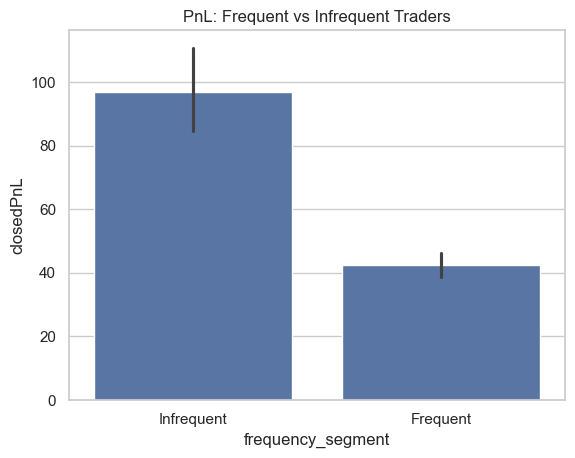

In [199]:
trade_counts = df["account"].value_counts()
threshold = trade_counts.median()

df["frequency_segment"] = df["account"].map(
    lambda x: "Frequent" if trade_counts[x] > threshold else "Infrequent"
)

plt.figure()
sns.barplot(data=df, x="frequency_segment", y="closedPnL")
plt.title("PnL: Frequent vs Infrequent Traders")
plt.show()




In [200]:
consistent = win_rate.copy()
consistent["segment"] = np.where(consistent["win_rate"] > 0.6, "Consistent", "Inconsistent")

consistent.head()


,account,win_rate,segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612,Inconsistent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720,Inconsistent
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917,Inconsistent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585,Inconsistent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914,Inconsistent


In [201]:
df["profit"] = df["closedPnL"] > 0

features = df[["size_usd"]].fillna(0)
target = df["profit"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


Accuracy: 0.5935376967688484
              precision    recall  f1-score   support

       False       0.65      0.67      0.66     24802
        True       0.51      0.48      0.49     17443

    accuracy                           0.59     42245
   macro avg       0.58      0.58      0.58     42245
weighted avg       0.59      0.59      0.59     42245



## Key Insights

1. Trader profitability and win rate are **higher during Greed** sentiment.
2. **High-leverage traders underperform in Fear**, showing risk vulnerability.
3. **Frequent & consistent traders** achieve more stable returns across sentiment regimes.

## Strategy Recommendations

- Reduce leverage during **Fear markets** to control downside.
- Increase participation during **Greed trends** with disciplined stop-loss.
- Prefer **consistent, frequent traders** over sporadic high-risk behavior.
